# Обзор
В блокноте показано, как инструменты Lime_image можно применять к небольшому набору данных, например mnist. Набор данных имеет очень низкое разрешение и позволяет выполнять довольно быстрые итерации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # поскольку код требует цветных изображений

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784')

mnist_array = mnist.data.to_numpy(dtype=np.uint8)

# сделайте каждое изображение цветом, чтобыLIME_image работал правильно
x_vec = np.stack([gray2rgb(iimg) for iimg in mnist_array.reshape((-1, 28, 28))],0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Digit: 5')

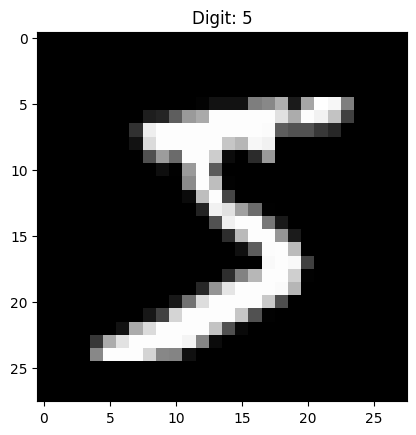

In [3]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(x_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

# Настройка конвейера
Здесь мы создаем конвейер для обработки изображений, где в основном мы сглаживаем изображение до одномерных векторов, а затем используем классификатор RandomForest.

In [4]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Wrapper for turning functions into pipeline transforms (no-fitting)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_vec, y_vec,
                                                    train_size=0.55)

In [6]:
simple_rf_pipeline.fit(x_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x7ef645702e30>),
                ('Flatten Image', <__main__.PipeStep object at 0x7ef645701db0>),
                ('RF', RandomForestClassifier())])

In [7]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 4.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=626af61617107441c98da647026ead85ea9cef5e2b5455a8d503032671caa7a8
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [8]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # добавить текущий каталог
    import lime

In [9]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [10]:
%%time
explanation = explainer.explain_instance(x_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)


  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 7.45 s, sys: 147 ms, total: 7.6 s
Wall time: 11.7 s


Text(0.5, 1.0, 'Positive/Negative Regions for 5')

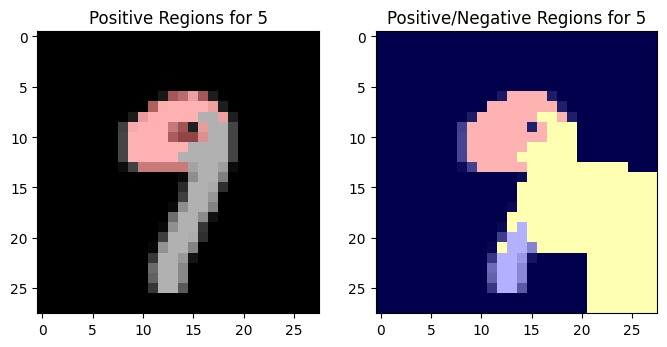

In [11]:
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01)
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (8, 4))
ax1.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
ax1.set_title('Positive Regions for {}'.format(y_test[0]))
temp, mask = explanation.get_image_and_mask(y_test[0], positive_only=False, num_features=10, hide_rest=False, min_weight = 0.01)
ax2.imshow(label2rgb(3-mask,temp, bg_label = 0), interpolation = 'nearest')
ax2.set_title('Positive/Negative Regions for {}'.format(y_test[0]))

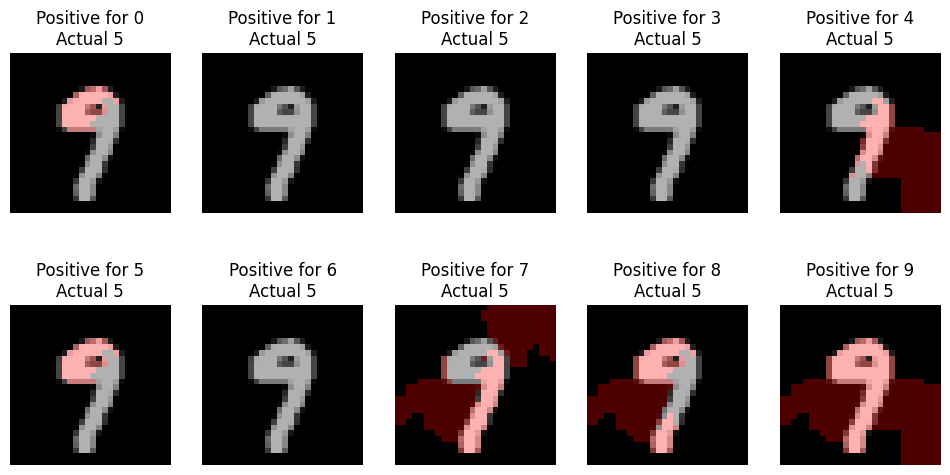

In [12]:
# теперь покажите их для каждого класса
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,x_test[0], bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[0]))
    c_ax.axis('off')

# Получение понимания
Можем ли мы найти объяснение классификации, в которой алгоритм ошибся?

In [13]:
pipe_pred_test = simple_rf_pipeline.predict(x_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Using #{} where the label was {} and the pipeline predicted {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Using #25604 where the label was 4 and the pipeline predicted 4


In [14]:
%%time
explanation = explainer.explain_instance(x_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 5.76 s, sys: 116 ms, total: 5.88 s
Wall time: 5.87 s


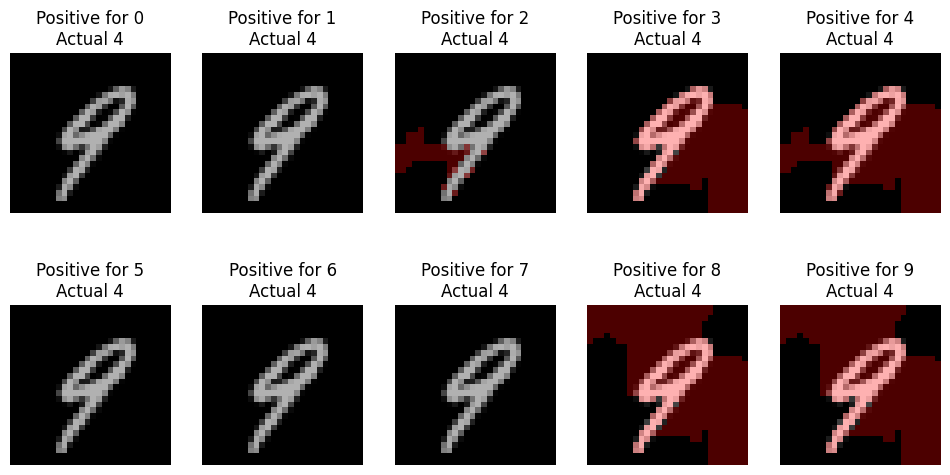

In [15]:
# теперь покажите их для каждого класса
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Positive for {}\nActual {}'.format(i, y_test[wrong_idx]))
    c_ax.axis('off')